In [1]:
'''
Adversarial Robustness Coursework on MNIST
--------------------------------------------
In this notebook, we will:
  - Train a fully-connected network (FCN) on the MNIST dataset using PyTorch.
  - Visualize MNIST images and report the standard test accuracy.
  - Implement and visualize the Fast Gradient Sign Method (FGSM) attack and report robust accuracy.
  - Introduce Assignment 1: Implementing Projected Gradient Descent (PGD) attack.
  - Provide a commented implementation of Interval Bound Propagation (IBP) using a center-radius method.
  - Report verified accuracy using IBP.
  - Introduce Assignment 2: Adversarial training with PGD.

Let's start by importing the necessary libraries.
''' 

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [2]:
# Define a simple Fully Connected Network (FCN) for MNIST
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        
    def forward(self, x):
        # Flatten the image
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Prepare the MNIST dataset and dataloaders
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the network, loss function, and optimizer
model = FCN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")


Epoch 1/5, Loss: 0.2855
Epoch 2/5, Loss: 0.1080
Epoch 3/5, Loss: 0.0706
Epoch 4/5, Loss: 0.0509
Epoch 5/5, Loss: 0.0384


Test Accuracy: 97.61%


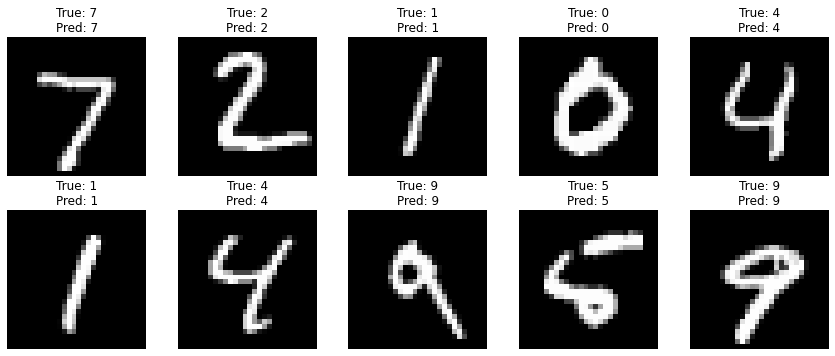

In [3]:
# Function to evaluate the model on the test dataset
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

test_acc = evaluate(model, test_loader)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Visualize a batch of MNIST images with their true labels and predictions
data_iter = iter(test_loader)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)
outputs = model(images)
preds = outputs.argmax(dim=1)

# Move data to CPU for visualization
images = images.cpu().numpy()

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.set_title(f"True: {labels[i].item()}\nPred: {preds[i].item()}")
    ax.axis('off')
plt.tight_layout()
plt.show()


FGSM Attack Robust Accuracy (epsilon=0.1): 15.74%


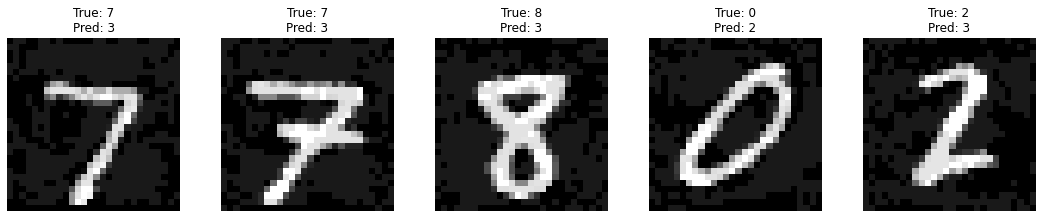

In [4]:
# Function to perform FGSM attack
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel
    perturbed_image = image + epsilon * sign_data_grad
    # Clamp to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

# Evaluate model robustness under FGSM attack on the test dataset
def test_fgsm(model, loader, epsilon):
    correct = 0
    adv_examples = []
    
    # Loop over all examples in test set
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        images.requires_grad = True
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Zero all existing gradients
        model.zero_grad()
        loss.backward()
        
        # Collect the data gradient
        data_grad = images.grad.data
        
        # Call FGSM Attack
        perturbed_data = fgsm_attack(images, epsilon, data_grad)
        
        # Re-classify the perturbed image
        output = model(perturbed_data)
        final_pred = output.argmax(dim=1)
        
        # Check for success
        correct += (final_pred == labels).sum().item()
        
        # Save some examples for visualization
        if len(adv_examples) < 5:
            adv_ex = perturbed_data[0].detach().cpu().numpy()
            adv_examples.append( (final_pred[0].item(), labels[0].item(), adv_ex) )
    
    final_acc = correct / len(loader.dataset)
    return final_acc, adv_examples

epsilon = 0.1  # Perturbation magnitude
robust_acc, adv_examples = test_fgsm(model, test_loader, epsilon)
print(f"FGSM Attack Robust Accuracy (epsilon={epsilon}): {robust_acc*100:.2f}%")

# Visualize some adversarial examples
fig, axes = plt.subplots(1, len(adv_examples), figsize=(15, 3))
for i, (pred, true, ex) in enumerate(adv_examples):
    axes[i].imshow(ex.squeeze(), cmap="gray")
    axes[i].set_title(f"True: {true}\nPred: {pred}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()


### Assignment 1: Implementing the PGD Attack

**Description:**

Projected Gradient Descent (PGD) is an iterative extension of the FGSM attack. In PGD, we:
1. Start from the original image.
2. At each iteration, take a small FGSM step (with a smaller step size than epsilon).
3. After each step, project the perturbed image back into the ε-ball around the original image to ensure the perturbation remains bounded.
4. Repeat for a fixed number of iterations.

**Your Task:**
- Implement the PGD attack using the above approach.
- Compare the robust accuracy obtained using PGD with the FGSM robust accuracy reported in Cell 4.
- Hint: Use a loop over iterations and consider a step size such as `alpha = epsilon / num_steps`.

Please provide your implementation and observations in the notebook.

### Additional Cell for Evaluation Purposes


No part of this assignment requires you to deal with IBP in any meaningful way. However, as we spent many slides
going over the intuition and formulation of IBP, I wanted to provide an implimentation that allows students to explore the ideas and operations that make IBP work. 

Feel free to use IBP as a metric for evaluating your robustly trained NN (Cell 2)

In [5]:
# The following is a simplified and commented implementation of Interval Bound Propagation (IBP)
# for a linear layer using the center-radius (interval) method.

def ibp_linear(W, b, lower, upper):
    """
    Compute the output bounds for a linear layer given input bounds.
    
    W: Weight matrix of shape (out_features, in_features)
    b: Bias vector of shape (out_features)
    lower: Lower bound of the input, shape (batch_size, in_features)
    upper: Upper bound of the input, shape (batch_size, in_features)
    """
    # Compute the center and radius of the input interval
    center = (lower + upper) / 2.0
    radius = (upper - lower) / 2.0
    
    # Linear transformation on the center
    new_center = center @ W.t() + b
    
    # Propagate the radius (using absolute weights)
    new_radius = radius @ torch.abs(W).t()
    
    # New bounds: center +/- radius
    new_lower = new_center - new_radius
    new_upper = new_center + new_radius
    return new_lower, new_upper

def ibp_relu(lower, upper):
    """
    Compute the output bounds for a ReLU activation.
    """
    # For ReLU, the lower bound is clamped at 0 and the upper bound is max(upper, 0)
    new_lower = torch.clamp(lower, min=0)
    new_upper = torch.clamp(upper, min=0)
    return new_lower, new_upper

# Example: Propagate bounds through our FCN for a given input image and perturbation radius.
# Let's take one sample from the test set.
model.eval()
sample_img, sample_label = next(iter(test_loader))
sample_img = sample_img[0:1].to(device)  # Select one image
epsilon_ibp = 0.0025

# Initialize bounds for the input image
lower_bound = torch.clamp(sample_img - epsilon_ibp, 0, 1)
upper_bound = torch.clamp(sample_img + epsilon_ibp, 0, 1)

# Flatten the image bounds
lower_bound = lower_bound.view(1, -1)
upper_bound = upper_bound.view(1, -1)

# IBP propagation through the network layers
# Layer 1: fc1
W1, b1 = model.fc1.weight, model.fc1.bias
l1_lower, l1_upper = ibp_linear(W1, b1, lower_bound, upper_bound)
l1_lower, l1_upper = ibp_relu(l1_lower, l1_upper)

# Layer 2: fc2
W2, b2 = model.fc2.weight, model.fc2.bias
l2_lower, l2_upper = ibp_linear(W2, b2, l1_lower, l1_upper)
l2_lower, l2_upper = ibp_relu(l2_lower, l2_upper)

# Layer 3: fc3 (output layer, no activation)
W3, b3 = model.fc3.weight, model.fc3.bias
output_lower, output_upper = ibp_linear(W3, b3, l2_lower, l2_upper)

# The bounds (output_lower, output_upper) now give us the interval for each logit.
print("IBP output lower bounds:", output_lower)
print("IBP output upper bounds:", output_upper)


IBP output lower bounds: tensor([[ -9.5672, -10.5665,  -2.5642,  -1.2760, -17.9483,  -7.5769, -27.7336,
          11.9040,  -8.7929,  -5.2747]], grad_fn=<SubBackward0>)
IBP output upper bounds: tensor([[ -2.2322,  -2.6372,   3.6805,   5.1960,  -9.8873,  -0.0344, -19.0694,
          19.0020,  -2.1640,   1.6714]], grad_fn=<AddBackward0>)


In [6]:
# Here, we perform a simple verification procedure.
# For each test example, if the lower bound for the true class is greater than 
# the upper bound for all other classes, we consider the prediction as verified robust.

def verify_sample(model, image, label, epsilon):
    image = image.unsqueeze(0).to(device)  # add batch dimension
    lower_bound = torch.clamp(image - epsilon, 0, 1)
    upper_bound = torch.clamp(image + epsilon, 0, 1)
    lower_bound = lower_bound.view(1, -1)
    upper_bound = upper_bound.view(1, -1)
    
    # Propagate bounds through the network (using IBP functions defined above)
    l1_lower, l1_upper = ibp_linear(model.fc1.weight, model.fc1.bias, lower_bound, upper_bound)
    l1_lower, l1_upper = ibp_relu(l1_lower, l1_upper)
    l2_lower, l2_upper = ibp_linear(model.fc2.weight, model.fc2.bias, l1_lower, l1_upper)
    l2_lower, l2_upper = ibp_relu(l2_lower, l2_upper)
    out_lower, out_upper = ibp_linear(model.fc3.weight, model.fc3.bias, l2_lower, l2_upper)
    
    # Check if for the true class, the lower bound exceeds the upper bounds of all others
    true_class_lb = out_lower[0, label]
    other_class_ubs = torch.cat([out_upper[0, :label], out_upper[0, label+1:]])
    
    return (true_class_lb > other_class_ubs).all().item()

verified = 0
total = 0
for images, labels in test_loader:
    for i in range(len(labels)):
        if verify_sample(model, images[i], labels[i].item(), epsilon_ibp):
            verified += 1
        total += 1

verified_accuracy = verified / total
print(f"Verified Accuracy (via IBP): {verified_accuracy*100:.2f}%")


Verified Accuracy (via IBP): 78.21%


### Assignment 2: Adversarial Training

**Description:**

Adversarial training is one of the most effective methods to improve model robustness. In this assignment, you are asked to modify the training loop (see Cell 2) to incorporate an adversary based on the PGD attack. Here are some guiding points:

1. **Adversary Generation:**  
   For each batch during training, generate adversarial examples using your PGD implementation (from Assignment 1). Use a suitable number of iterations and a step size (e.g., `alpha = epsilon / num_steps`).

2. **Modified Loss:**  
   You may consider computing the loss on both the original and adversarial examples. One common approach is to use a weighted sum of the two losses.

3. **Training Loop:**  
   Update the training loop to include the generation of adversarial examples on-the-fly, and then perform the backward pass based on the modified loss.

4. **Evaluation:**  
   After adversarial training, evaluate your model’s robust accuracy (using FGSM and/or PGD attacks) and compare it with the baseline results from Cell 4.

**Your Task:**
- Implement the modifications to perform adversarial training.
- Provide a discussion of the robustness gains (or potential trade-offs) observed after training.

Please include your code modifications and analysis in the notebook.

### Hint 1: Use the training loop provided at the start of the notebook as a starting template
### Hint 2: Once you have a working prototype you might want to vectorize your PGD implimentation to speed things up!